In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from matplotlib.colors import TwoSlopeNorm
import matplotlib.colors as colors
from celmech import Andoyer
import rebound
from celmech.andoyer import get_Xstarres, get_Xstarunstable, get_Xstarnonres, get_Xsep
import pdb
from statsmodels.stats.weightstats import DescrStatsW
import corner
from tqdm import tqdm
from celmech.andoyer import get_Hsep
import glob
import pandas as pd
import spock
from spock import FeatureClassifier
from statsmodels.stats.weightstats import DescrStatsW
from scipy import stats

In [2]:
# last TESS observation:
t_tess = 4664.65

# last K2 observation:
t_K2 = 2265

t = t_tess - t_K2

t_orbits = t/8.24958

#print('Number of orbits between observations: {:.0f}'.format(t_orbits))

t_orb = t_orbits*5.98
tmax = 1.0*t_orb
Nout = 200

t = np.linspace(0,tmax,Nout)
obs_tess = np.where(np.round(abs(t - t_orb),6) == np.round(np.min(abs(t - t_orb)),6))[0][0] 

delta_index = 0
obs_idx=[delta_index,obs_tess+delta_index] # [20, 519] in the current version

nobs = 2
obs_err = np.array([0.0001, 0.0005])
obs = np.array([1.503, 1.503]) 

def makesim(theta,dt=None):
    if dt==None:
        e_forced, e_free, mu, deltaT = theta
    else:
        e_forced, e_free, mu = theta[0], theta[1], theta[2]
        deltaT = dt
    mratio=0.5
    #e_com=float(np.random.uniform(0, 0.3, size=1)),  # varying between 0 and max(Z*) = 0.3
    e_com = 0.0
    phiecom=float(np.random.uniform(0, 2*np.pi, size=1)) # varying between 0 and 2pi
    #phiecom=0.0
    theta1 = np.pi
    #pomega_b=None
    
    Mstar = 1.1
    m1 = mratio*10**mu
    m2 = (1-mratio)*10**mu
    phi = np.pi # where equilibrium is
    theta1 = np.pi # so they start on opposite sides

    andvars = Andoyer.from_Z(j=3, k=1, Z=(e_forced+e_free)/np.sqrt(2), phi=phi, 
                             Zstar=e_forced/np.sqrt(2), Mstar=Mstar, m1=m1, m2=m2, 
                             Zcom=e_com/np.sqrt(2), phiZcom=phiecom, theta1=theta1)

    try:
        sim = andvars.to_Simulation()
        sim.integrator="whfast"
        #sim.init_megno()
        sim.dt = sim.particles[1].P/20
        sim.ri_whfast.safe_mode = 0
        sim.integrate(deltaT)
        sim.t = 0
        return sim
    except:
        print(e_forced, e_free, deltaT, mu)
        raise
        
def run(sim):
    
    Pratios = np.zeros(Nout)
    ps = sim.particles
    sim.init_megno()
    
    for i, time in enumerate(t):
        
        sim.integrate(time)
        Pratios[i] = ps[2].P/ps[1].P
        
    megno = sim.calculate_megno()
    return Pratios,megno
        
def get_Phinorm(post_array):
    np.random.seed(0)
    phi, Phinorm = np.zeros(len(post_array)), np.zeros(len(post_array))
    # see separatrix note on Dan's ipad
    for i, p in tqdm(enumerate(post_array)):
        sim = makesim(p, dt=0)
        andvars = Andoyer.from_Simulation(sim, j=j, k=k)
        Phiprime = andvars.Phiprime
        Xstarres = get_Xstarres(k, Phiprime)
        Xsep_inner, Xsep_outer = get_Xsep(k, Phiprime)
        Phistarres = Xstarres**2/2
        Phisep_outer = Xsep_outer**2/2
        sim = makesim(p, dt=np.random.random()*2000)
        #sim = makesim(p, dt=0.0)
        andvars = Andoyer.from_Simulation(sim, j=j, k=k)
        Phinorm[i] = (andvars.Phi-Phistarres)/(Phisep_outer - Phistarres)
        phi[i] = andvars.phi
        
    return phi, Phinorm

def get_H(andvars):
    X = andvars.X
    Y = andvars.Y
    k = andvars.params['k']
    Phiprime = andvars.Phiprime
    H = (X**2 + Y**2)**2 - 3*Phiprime/2*(X**2+Y**2)+(X**2+Y**2)**((k-1)/2)*X 
    return H


def get_deltaH(post_array, j, k, i1, i2, pl_b=True):

    #j1 = 3
    #j2 = 2
    #k = 1

    deltaH = []

    for i,param in tqdm(enumerate(post_array)):
        sim = makesim(param[:4],dt=0)
        
        if pl_b:
            m_b = 10**param[-2]
            e_b = param[-1]

            pomega_b = float(np.random.uniform(0, 2*np.pi, size=1))
            sim.add(m=m_b, P=sim.particles[2].P*1.946, e=e_b, pomega=pomega_b, theta=np.pi/2)
        
        #if both:
        andvars = Andoyer.from_Simulation(sim, j=j, k=k, i1=i1, i2=i2)

        H = get_H(andvars)
        Hsep = get_Hsep(k, andvars.Phiprime)

        deltaH.append(H-Hsep)
        
    return deltaH

In [3]:
rv_post = np.load('stability_posteriors/100k_rv_priors_60mil_lnlike_randomtheta.npy')
preds_rv = np.load('stability_posteriors/100k_rv_stability_preds_randomtheta.npy')

# Checking the lifetimes of the bottom 50th sum percentile.

We want to see at what point the sum of the SPOCK probabilities is half of the total SPOCK probability sum, then take a look at their lifetimes and see what the median lifetimes are.

In [4]:
plt.figure(figsize=(10,5))
hist = plt.hist(preds_rv[preds_rv != 0.0],histtype='step',bins='auto')
#plt.axvline(0.02,color='k')
plt.xlabel('SPOCK probability')
plt.ylabel('N')

Text(0, 0.5, 'N')

In [5]:
np.where(preds_rv == np.sum(preds_rv)/2)[0]

array([], dtype=int64)

In [6]:
s_test = np.sum(preds_rv[:0])
s_test

0.0

In [7]:
test = np.random.randint(10,size=10)
test

array([9, 7, 5, 0, 8, 6, 8, 0, 0, 4])

In [8]:
np.sort(test)

array([0, 0, 0, 4, 5, 6, 7, 8, 8, 9])

In [9]:
thresh_index = []
for i,pred in enumerate(preds_rv[preds_rv != 0.0]):
    s = np.sum(np.sort(preds_rv[preds_rv != 0.0])[:i])
    if s <= np.sum(preds_rv[preds_rv != 0.0])/5:
        continue
    else:
        print(s, i)
        thresh_index.append(i)
        break

581.6944 17802


In [10]:
#half_thresh = np.sort(preds_rv[preds_rv != 0.0])[24260]
fifth_thresh = np.sort(preds_rv[preds_rv != 0.0])[17802]

print(fifth_thresh)

0.08389807


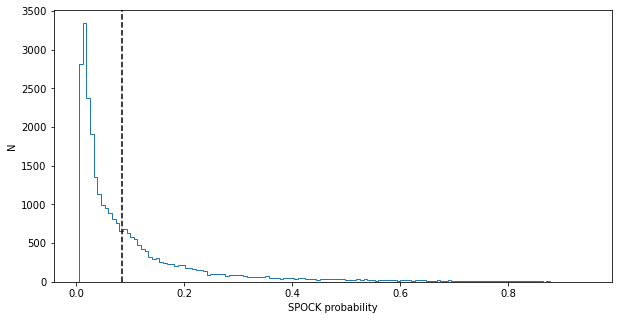

In [11]:
%matplotlib inline
plt.figure(figsize=(10,5))
hist = plt.hist(preds_rv[preds_rv != 0.0],histtype='step',bins='auto')
plt.axvline(fifth_thresh,color='k', ls='--')
#plt.axvline(half_thresh,color='k', ls='--') # 50th sum percentile
plt.xlabel('SPOCK probability')
plt.ylabel('N')
plt.show()

In [12]:
rv_stable = rv_post[preds_rv != 0.0]
preds_stable = preds_rv[preds_rv != 0.0]

In [14]:
# configs below these thresholds

rv_fifth = rv_stable[preds_stable < fifth_thresh]
#rv_half = rv_stable[preds_stable < half_thresh]
print(len(rv_fifth))

17802


In [15]:
fifth_idx = np.where(preds_stable < fifth_thresh)[0]

In [16]:
# doing the fifth first
m_b_rv = [param[-2] for param in rv_fifth]
e_b_rv = [param[-1] for param in rv_fifth]

params_cd = [list(rv_fifth[i][:4]) for i in range(len(rv_fifth))]
#deltaTs = [params_rv[i][-2] for i in range(len(params_rv))]

#for p1,p2 in zip(params_cd, deltaTs):
#    p1.append(p2)
    
params_b = [[m_b, e_b] for m_b, e_b in zip(m_b_rv, e_b_rv)]

In [17]:
def makesim2(param_cd, param_b, seed, dt=None):
    sim = makesimcd(param_cd[:4], dt=dt)
    
    m_b = 10**param_b[0]
    e_b = param_b[1]
    np.random.seed(seed)
    pomega_b = float(np.random.uniform(0, 2*np.pi, size=1))
    theta_b = float(np.random.uniform(0, 2*np.pi, size=1))
    sim.add(m=m_b, P=sim.particles[2].P*1.946, e=e_b, pomega=pomega_b, theta=theta_b)
    sim.move_to_com()
    return sim

def makesimcd(param_cd,dt=None):
    e_forced, e_free, mu, deltaT = param_cd
    if dt:
        deltaT = dt
    mratio=0.5
    e_com = 0.0
    
    Mstar = 1.1
    m1 = mratio*10**mu
    m2 = (1-mratio)*10**mu
    phi = np.pi # where equilibrium is
    theta1 = np.pi # so they start on opposite sides

    andvars = Andoyer.from_Z(j=3, k=1, Z=(e_forced+e_free)/np.sqrt(2), phi=phi, 
                             Zstar=e_forced/np.sqrt(2), Mstar=Mstar, m1=m1, m2=m2, 
                             Zcom=e_com/np.sqrt(2), phiZcom=0, theta1=theta1)

    try:
        sim = andvars.to_Simulation()
        sim.integrator="whfast"
        sim.dt = sim.particles[1].P/20
        sim.ri_whfast.safe_mode = 0
        sim.integrate(deltaT)
        sim.t = 0
        return sim
    except:
        print(e_forced, e_free, deltaT, mu)
        raise

In [18]:
deep_regressor = spock.DeepRegressor(cuda=False)

In [19]:
sim_list = []
pbar = tqdm(total=len(rv_fifth))
for i,(pcd,pb) in enumerate(zip(params_cd, params_b)):
    #if i == 66986:
    #    continue
    sim = makesim2(pcd, pb, seed=fifth_idx[i])
    sim_list.append(sim)
    pbar.update()
pbar.close()

100%|██████████| 17802/17802 [02:13<00:00, 133.59it/s]


In [23]:
for sim in tqdm(sim_list[:10]):
    median, lower, upper = deep_regressor.predict_instability_time(sim)
    #print(np.log10(median))

 10%|█         | 1/10 [00:20<03:07, 20.79s/it]

5.720351133915771


 20%|██        | 2/10 [00:41<02:45, 20.70s/it]

5.7080162702944595
3.280552835417166
3.814835618510665


 50%|█████     | 5/10 [01:01<00:53, 10.78s/it]

7.357065233553821


 60%|██████    | 6/10 [01:22<00:52, 13.24s/it]

5.923335888371883


 70%|███████   | 7/10 [01:42<00:45, 15.17s/it]

5.701665554030128


 80%|████████  | 8/10 [02:03<00:33, 16.63s/it]

5.500130253891548


 90%|█████████ | 9/10 [02:23<00:17, 17.71s/it]

5.479219247681582


100%|██████████| 10/10 [02:44<00:00, 16.42s/it]

6.72387196926725


In [ ]:
n = hist[0]
edges = hist[1]

In [ ]:
max_prob = edges[np.where(n == np.max(n))]
print(max_prob)

In [ ]:
deltaH_cd = np.load('deltaH_cd_randomtheta.npy')
deltaH_db = np.load('deltaH_db_randomtheta.npy')

phi_rv = np.load('stability_posteriors/phi_rv_randomtheta.npy')
Phinorm_rv = np.load('stability_posteriors/Phinorm_rv_randomtheta.npy')

In [ ]:
rv_inres = np.array(rv_post)[(np.array(deltaH_cd) < 0.0) & (preds_rv != 0.0)] 
rv_outres = np.array(rv_post)[(np.array(deltaH_cd) >= 0.0) | np.isnan(np.array(deltaH_cd))]

print(len(rv_inres))
print(len(rv_outres))

In [ ]:
len(np.array(rv_post)[(np.array(deltaH_cd) < 0.0)])/len(rv_post)

In [ ]:
len(rv_inres)/len(rv_post)

In [ ]:
rv_inres[0]

In [ ]:
efrees = np.array([param[1] for param in rv_inres])
mus = np.array([param[2] for param in rv_inres])

In [ ]:
test = rv_inres[mus == np.max(mus)][0]

In [ ]:
test

In [ ]:
test2 = rv_inres[mus == np.median(mus)][0]
test2

In [ ]:
fig = plt.figure(1,figsize=(7*3.4, 2.5*3.4*3/4.))
ax = fig.add_subplot(111)
time_grid = np.linspace(t_K2, t_tess, Nout)

size=100

c_efree = np.logspace(-4,-1.5, 100)
#c_mu2 = np.array([(10**param[-2])/9.54e-4 for param in rv_inres_deltaT[:size]])
norm = mpl.colors.Normalize(vmin=c_efree.min(), vmax=c_efree.max())
#norm2 = mpl.colors.Normalize(vmin=c_mu2.min(), vmax=c_mu2.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.magma)
#cmap2 = mpl.cm.ScalarMappable(norm=norm2, cmap=mpl.cm.viridis)
cmap.set_array([])
#cmap2.set_array([])

for i,ef in tqdm(enumerate(c_efree)):
#    if i == 0:
#        sim = makesim(test[:4])
#        period_ratios = run(sim) 
#        ax.plot(time_grid,period_ratios,
#             alpha=1.0,zorder=0, c='k',lw=5.0,
#             rasterized=True)
#    else:
    test2[1] = ef

    sim = makesim(test2[:4])
    period_ratios = run(sim)

    ax.plot(time_grid,period_ratios,
         alpha=0.5,zorder=1, c=cmap.to_rgba(c_efree[i]),
         rasterized=True)

ax.errorbar(time_grid[[0, -1]],obs,yerr=obs_err, fmt='o',ms=7, c='r',ecolor='b',zorder=1,capsize=5, capthick=2)
ax.set_ylabel('Period ratio [P$_d$/P$_c$]',fontsize=30)
#ax.set_ylim(1.493, 1.510)
ax.set_xlabel('Time [BKJD - 2454833]',fontsize=30)

ax.tick_params(axis='y', labelsize=30)
ax.tick_params(axis='x', labelsize=30)

t_cbar = fig.colorbar(cmap)
t_cbar.set_label(r'$e_{\rm{free}}$', fontsize=25)
t_cbar.ax.tick_params(labelsize=30)
plt.show()
#plt.savefig('figures/Figure2b.pdf',dpi=300,bbox_inches='tight',padding=0)

In [ ]:
c_efree = np.logspace(-6,-1.3, 300)
test2 = test.copy()
zfree_params = []
for i,ef in enumerate(c_efree):
    test3 = test2.copy()
    test3[1] = ef
    zfree_params.append(test3[:4])

In [ ]:
%matplotlib inline
fig = plt.figure(1,figsize=(4*3.4, 4.0*3.4*3/4.)
                         #gridspec_kw={'width_ratios': [1, 0.80]}
                       )
ax1 = fig.add_subplot(111)
#ax2 = axes[1]

phis = np.linspace(0, 2*np.pi, 1000)
sep_upper = np.sin(phis/2)
ax1.plot(phis, sep_upper, 'k')
ax1.plot(phis, -sep_upper, 'k')
ax1.set_xlim([0,2*np.pi])
ax1.set_xlabel('Resonant angle $\phi$',fontsize=30)
ax1.set_ylabel('Normalized period ratio deviation',fontsize=30)
#cb = ax.scatter(phi, Phinorm, c=spock_prob, alpha=spock_prob, s=20)
    
j = 3
k = 1
catseye_test = np.array(zfree_params)

phi_test, Phinorm_test = get_Phinorm(catseye_test)



cb=ax1.scatter(phi_test, Phinorm_test, 
              c=c_efree,norm=colors.LogNorm(vmin=c_efree.min(), vmax=c_efree.max()),
              s=10, rasterized=True,cmap='viridis')
ax1.axhline(0.0)
#cb=ax1.scatter(phi_rv, Phinorm_rv, 
#              c=[param[2] for param in rv_inres], 
#              s=10, rasterized=True)

cbar1 = fig.colorbar(cb, ax=ax1)
cbar1.set_label(r'$e_{\rm{free}}$', fontsize=30)
cbar1.ax.tick_params(labelsize=30)

ax1.minorticks_on()

ax1.tick_params(axis='y', labelsize=30)
ax1.tick_params(axis='x', labelsize=30)

#plt.tight_layout()
#plt.subplots_adjust(wspace=0.07)
plt.show()
#plt.savefig('figures/Figure2_stability.pdf',dpi=300,bbox_inches='tight',padding=0)

In [ ]:
fig = plt.figure(1,figsize=(7*3.4, 2.5*3.4*3/4.))
ax = fig.add_subplot(111)
time_grid = np.linspace(t_K2, t_tess, Nout)

#size=100

#c_efree = np.logspace(-4,-1.5, 100)
#c_mu2 = np.array([(10**param[-2])/9.54e-4 for param in rv_inres_deltaT[:size]])
norm = mpl.colors.Normalize(vmin=c_efree.min(), vmax=c_efree.max())
#norm2 = mpl.colors.Normalize(vmin=c_mu2.min(), vmax=c_mu2.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.viridis)
#cmap2 = mpl.cm.ScalarMappable(norm=norm2, cmap=mpl.cm.viridis)
cmap.set_array([])
#cmap2.set_array([])

for i,param in tqdm(enumerate(zfree_params)):
    #test[1] = ef

    sim = makesim(param)
    #megno = sim.calculate_megno()
    period_ratios, megno = run(sim)

    ax.plot(time_grid,period_ratios,
         alpha=0.5,zorder=1, c=cmap.to_rgba(c_efree[i]),
            #norm=colors.LogNorm(vmin=c_efree.min(), vmax=c_efree.max()),
         rasterized=True)

ax.errorbar(time_grid[[0, -1]],obs,yerr=obs_err, fmt='o',ms=7, c='r',ecolor='b',zorder=1,capsize=5, capthick=2)
ax.set_ylabel('Period ratio [P$_d$/P$_c$]',fontsize=30)
#ax.set_ylim(1.493, 1.510)
ax.set_xlabel('Time [BKJD - 2454833]',fontsize=30)

ax.tick_params(axis='y', labelsize=30)
ax.tick_params(axis='x', labelsize=30)

t_cbar = fig.colorbar(cmap)
t_cbar.set_label(r'$e_{\rm{free}}$', fontsize=25)
t_cbar.ax.tick_params(labelsize=30)
plt.show()
#plt.savefig('figures/Figure2b.pdf',dpi=300,bbox_inches='tight',padding=0)

In [ ]:
sim_list = [makesim(param) for param in zfree_params]

In [ ]:
megno_test = np.array([run(sim)[1] for sim in sim_list])

In [ ]:
megno_test[megno_test >= 2.0]

In [ ]:
%matplotlib inline
fig = plt.figure(1,figsize=(7*3.4, 4.0*3.4*3/4.)
                         #gridspec_kw={'width_ratios': [1, 0.80]}
                       )
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

phis = np.linspace(0, 2*np.pi, 1000)
sep_upper = np.sin(phis/2)
ax1.plot(phis, sep_upper, 'k')
ax1.plot(phis, -sep_upper, 'k')
ax1.set_xlim([0,2*np.pi])
ax1.set_xlabel('Resonant angle $\phi$',fontsize=30)
ax1.set_ylabel('Normalized period ratio deviation',fontsize=30)
#cb = ax.scatter(phi, Phinorm, c=spock_prob, alpha=spock_prob, s=20)
    
#j = 3
#k = 1
#catseye_test = np.array(zfree_params)

#phi_test, Phinorm_test = get_Phinorm(catseye_test)

ax1.scatter(phi_test[megno_test < 2.0], Phinorm_test[megno_test < 2.0], 
              c='k',
              s=30, rasterized=True, label="MEGNO $< 2.0$")
ax1.scatter(phi_test[megno_test >= 2.0], Phinorm_test[megno_test >= 2.0], 
              c='r',
              s=30, rasterized=True, label="MEGNO $\geq 2.0$")

#cbar1 = fig.colorbar(cb, ax=ax1)
#cbar1.set_label(r'$e_{\rm{free}}$', fontsize=30)
#cbar1.ax.tick_params(labelsize=30)
ax1.legend()

ax1.minorticks_on()

ax1.tick_params(axis='y', labelsize=30)
ax1.tick_params(axis='x', labelsize=30)
ax1.set_ylim(-1.2, 1.2)

ax2.plot(phis, sep_upper, 'k')
ax2.plot(phis, -sep_upper, 'k')
ax2.set_xlim([0,2*np.pi])
ax2.set_xlabel('Resonant angle $\phi$',fontsize=30)
#ax2.set_ylabel('Normalized period ratio deviation',fontsize=30)
#cb = ax.scatter(phi, Phinorm, c=spock_prob, alpha=spock_prob, s=20)
    
#j = 3
#k = 1
#catseye_test = np.array(zfree_params)

#phi_test, Phinorm_test = get_Phinorm(catseye_test)

ax2.scatter(phi_rv, Phinorm_rv, alpha=0.1,
              c='k',
              s=30, rasterized=True)

ax2.scatter(phi_test[megno_test < 2.0], Phinorm_test[megno_test < 2.0], 
              c='b',
              s=40, rasterized=True, label="MEGNO $< 2.0$")
ax2.scatter(phi_test[megno_test >= 2.0], Phinorm_test[megno_test >= 2.0], 
              c='r',
              s=40, rasterized=True, label="MEGNO $\geq 2.0$")

u1 = np.pi
v1 = -0.02
a1 = 0.58
b1 = 0.22
theta = np.linspace(0, 2*np.pi, len(phi_rv))
#ax2.plot(u1+a1*np.cos(theta),v1+b1*np.sin(theta), c='g', lw=3)

u2 = np.pi
v2 = -0.02
a2 = 1.55*0.58
b2 = 1.55*0.19
theta = np.linspace(0, 2*np.pi, len(phi_rv))
#ax2.plot(u2+a2*np.cos(theta),v2+b2*np.sin(theta), c='g', lw=3)
ax2.axhline(b2, lw=2)
ax2.axhline(b1, lw=2)
ax2.axvline(np.pi - a1, lw=2)
ax2.axvline(np.pi + a1, lw=2)

ax2.minorticks_on()

ax2.tick_params(axis='y', labelsize=30)
ax2.tick_params(axis='x', labelsize=30)
ax2.set_ylim(-1.2, 1.2)

#plt.tight_layout()
#plt.subplots_adjust(wspace=0.07)
plt.show()
#plt.savefig('figures/Figure2_stability.pdf',dpi=300,bbox_inches='tight',padding=0)

In [ ]:
lower_phi, lower_phinorm = u1+a1*np.cos(theta),v1+b1*np.sin(theta)
upper_phi, upper_phinorm = u2+a2*np.cos(theta),v2+b2*np.sin(theta)

In [ ]:
# the first one is also stable but we wanna know how many unstable we have in the region
rv_inres2 = rv_post[deltaH_cd < 0.0]
preds_inres = preds_rv[deltaH_cd < 0.0]
print(len(rv_inres2), len(preds_inres))

In [ ]:
empty_region_test = rv_inres2[(Phinorm_rv > b1) & (phi_rv > np.pi - a1) &\
                              (Phinorm_rv < b2) & (phi_rv < np.pi + a2)]

empty_region_probs = preds_inres[(Phinorm_rv > b1) & (phi_rv > np.pi - a1) &\
                              (Phinorm_rv < b2) & (phi_rv < np.pi + a2)]

print(len(empty_region_test),len(empty_region_probs))

In [ ]:
len(empty_region_test[empty_region_probs == 0.0])/len(empty_region_test)

In [ ]:
plt.hist(empty_region_probs[empty_region_probs != 0.0],histtype='step',bins=50)
plt.xlabel('non-zero SPOCK probabilities in empty region')
plt.show()

In [ ]:
sim_list_b = []
for i, param in enumerate(empty_region_test):
    sim = makesim(param[:4])
    pomega_b = float(np.random.uniform(0, 2*np.pi, size=1))
    theta_b = float(np.random.uniform(0, 2*np.pi, size=1))
    sim.add(m = 10**param[-2], P=sim.particles[2].P*1.946, e=param[-1], pomega=pomega_b, theta=theta_b)
    sim_list_b.append(sim)

In [ ]:
model = FeatureClassifier()
model.predict_stable(sim_list_b[0])

In [ ]:
model.generate_features(sim_list_b[0])

In [ ]:
megno = np.array([model.generate_features(sim)[0][0]['MEGNO'] for sim in sim_list_b])

In [ ]:
np.sum(~np.isnan(megno))

In [ ]:
megno_ = megno[np.where(~np.isnan(megno))[0]]
len(megno_[megno_ > 2.5])/len(megno_)

In [ ]:
plt.figure(figsize=(10,8))
plt.scatter(empty_region_probs[np.where(~np.isnan(megno))[0]], megno[np.where(~np.isnan(megno))[0]])
plt.axhline(y=2.0, c='r')
plt.xlabel('SPOCK prob.')
plt.ylabel('MEGNO SPOCK feature')
#plt.yscale('log')

In [ ]:
sim_list_c = []
for i, param in tqdm(enumerate(rv_inres2)):
    sim = makesim(param[:4])
    pomega_b = float(np.random.uniform(0, 2*np.pi, size=1))
    theta_b = float(np.random.uniform(0, 2*np.pi, size=1))
    sim.add(m = 10**param[-2], P=sim.particles[2].P*1.946, e=param[-1], pomega=pomega_b, theta=theta_b)
    sim_list_c.append(sim)

In [ ]:
megno_arr = np.array([model.generate_features(sim)[0][0]['MEGNO'] for sim in tqdm(sim_list_c)])

In [ ]:
len(megno_arr)

In [ ]:
megno_arr

In [ ]:
len(np.where(~np.isnan(megno_arr))[0])

In [ ]:
len(megno_arr[megno_arr > 2.5])

In [ ]:
len(megno_arr[megno_arr <= 2.5])

In [ ]:
%matplotlib inline
fig = plt.figure(1,figsize=(4.0*3.4, 4.0*3.4*3/4.)
                         #gridspec_kw={'width_ratios': [1, 0.80]}
                       )
#ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(111)

phis = np.linspace(0, 2*np.pi, 1000)
sep_upper = np.sin(phis/2)

ax2.plot(phis, sep_upper, 'k')
ax2.plot(phis, -sep_upper, 'k')
ax2.set_xlim([0,2*np.pi])
ax2.set_xlabel('Resonant angle $\phi$',fontsize=30)
ax2.set_xlabel('Resonant angle $\phi$',fontsize=30)
#ax2.set_ylabel('Normalized period ratio deviation',fontsize=30)
#cb = ax.scatter(phi, Phinorm, c=spock_prob, alpha=spock_prob, s=20)
    
#j = 3
#k = 1
#catseye_test = np.array(zfree_params)

#phi_test, Phinorm_test = get_Phinorm(catseye_test)
megno_arr_ = megno_arr[np.where(~np.isnan(megno_arr))[0]]
cb=ax2.scatter(phi_rv[np.where(~np.isnan(megno_arr))[0]], Phinorm_rv[np.where(~np.isnan(megno_arr))[0]], 
              c=megno_arr_,norm=colors.LogNorm(vmin=megno_arr_.min(), vmax=megno_arr_.max()),
              s=10, rasterized=True,cmap='gnuplot')
#cb=ax1.scatter(phi_rv, Phinorm_rv, 
#              c=[param[2] for param in rv_inres], 
#              s=10, rasterized=True)

cbar1 = fig.colorbar(cb, ax=ax2)
cbar1.set_label(r'MEGNO', fontsize=30)
cbar1.ax.tick_params(labelsize=30)

#ax2.scatter(phi_test[megno_test < 2.0], Phinorm_test[megno_test < 2.0], 
#              c='b',
#              s=40, rasterized=True, label="MEGNO $< 2.0$")
#ax2.scatter(phi_test[megno_test >= 2.0], Phinorm_test[megno_test >= 2.0], 
#              c='r',
#              s=40, rasterized=True, label="MEGNO $\geq 2.0$")
#ax2.axhline(b2, lw=1)
#ax2.axhline(b1, lw=1)
#ax2.axvline(np.pi - a1, lw=1)
#ax2.axvline(np.pi + a1, lw=1)

ax2.minorticks_on()

ax2.tick_params(axis='y', labelsize=30)
ax2.tick_params(axis='x', labelsize=30)
ax2.set_ylim(-1.2, 1.2)

#plt.tight_layout()
#plt.subplots_adjust(wspace=0.07)
plt.show()
#plt.savefig('figures/Figure2_stability.pdf',dpi=300,bbox_inches='tight',padding=0)

In [ ]:
def spock_pred(simlist):
    model = FeatureClassifier()
    return model.predict_stable(simlist)

In [ ]:
c_efree = np.logspace(-6,-1.3, 300)
test4 = test.copy()
zfree_params = []
for i,ef in enumerate(c_efree):
    test5 = test4.copy()
    test5[1] = ef
    zfree_params.append(test5)

In [ ]:
test

In [ ]:
sim_list_b = []
for i, param in enumerate(zfree_params):
    sim = makesim(param[:4])
    pomega_b = float(np.random.uniform(0, 2*np.pi, size=1))
    theta_b = float(np.random.uniform(0, 2*np.pi, size=1))
    sim.add(m = 10**param[-2], P=sim.particles[2].P*1.946, e=param[-1], pomega=pomega_b, theta=theta_b)
    sim_list_b.append(sim)

In [ ]:
spock_prob_test = spock_pred(sim_list_b)

In [ ]:
spock_prob_test

In [ ]:
%matplotlib inline
fig = plt.figure(1,figsize=(7*3.4, 4.0*3.4*3/4.)
                         #gridspec_kw={'width_ratios': [1, 0.80]}
                       )
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

phis = np.linspace(0, 2*np.pi, 1000)
sep_upper = np.sin(phis/2)
ax1.plot(phis, sep_upper, 'k')
ax1.plot(phis, -sep_upper, 'k')
ax1.set_xlim([0,2*np.pi])
ax1.set_xlabel('Resonant angle $\phi$',fontsize=30)
ax1.set_ylabel('Normalized period ratio deviation',fontsize=30)


ax1.scatter(phi_test[megno_test < 2.0], Phinorm_test[megno_test < 2.0], 
              c='k',
              s=30, rasterized=True, label="MEGNO $< 2.0$")
ax1.scatter(phi_test[megno_test >= 2.0], Phinorm_test[megno_test >= 2.0], 
              c='r',
              s=30, rasterized=True, label="MEGNO $\geq 2.0$")

#ax1.plot(x,y)

#cbar1 = fig.colorbar(cb, ax=ax1)
#cbar1.set_label(r'$e_{\rm{free}}$', fontsize=30)
#cbar1.ax.tick_params(labelsize=30)
ax1.legend()

ax1.minorticks_on()

ax1.tick_params(axis='y', labelsize=30)
ax1.tick_params(axis='x', labelsize=30)
ax1.set_ylim(-1.2, 1.2)

ax2.plot(phis, sep_upper, 'k')
ax2.plot(phis, -sep_upper, 'k')
ax2.set_xlim([0,2*np.pi])
ax2.set_xlabel('Resonant angle $\phi$',fontsize=30)
ax2.set_ylabel('Normalized period ratio deviation',fontsize=30)
#cb = ax.scatter(phi, Phinorm, c=spock_prob, alpha=spock_prob, s=20)
    
#j = 3
#k = 1
#catseye_test = np.array(zfree_params)

#phi_test, Phinorm_test = get_Phinorm(catseye_test)

ax2.scatter(phi_test[megno_test < 2.0], Phinorm_test[megno_test < 2.0], 
              c='k',
              s=30, rasterized=True, label="MEGNO $< 2.0$", alpha=spock_prob_test[megno_test<2.0])
ax2.scatter(phi_test[megno_test >= 2.0], Phinorm_test[megno_test >= 2.0], 
              c='r',
              s=30, rasterized=True, label="MEGNO $\geq 2.0$", alpha=spock_prob_test[megno_test>=2.0])

#cbar1 = fig.colorbar(cb, ax=ax1)
#cbar1.set_label(r'$e_{\rm{free}}$', fontsize=30)
#cbar1.ax.tick_params(labelsize=30)
#ax1.legend()

ax2.minorticks_on()

ax2.tick_params(axis='y', labelsize=30)
ax2.tick_params(axis='x', labelsize=30)
ax2.set_ylim(-1.2, 1.2)

#plt.tight_layout()
#plt.subplots_adjust(wspace=0.07)
plt.show()
#plt.savefig('figures/Figure2_stability.pdf',dpi=300,bbox_inches='tight',padding=0)

# Getting all configs that appear between the cat's eye rings...

Selecting all in-resonance and stable configs that lie in the cat's eye gap between 0.2 < Phinorm < 0.3

In [ ]:
bet = rv_inres[(Phinorm_rv[preds_rv[deltaH_cd < 0.0] != 0.0] > 0.2) &\
               (Phinorm_rv[preds_rv[deltaH_cd < 0.0] != 0.0] < 0.3) &\
              (phi_rv[preds_rv[deltaH_cd < 0.0] != 0.0] < 3.4)&\
              (phi_rv[preds_rv[deltaH_cd < 0.0] != 0.0] > 3.0)]
len(bet)

In [ ]:
bet

In [ ]:
fig = plt.figure(1,figsize=(2.2*3.4, 1.2*3.4*3/4.))
ax = fig.add_subplot(111)
time_grid = np.linspace(t_K2, t_tess, Nout)

for i,param in tqdm(enumerate(bet)):
    p = param[:4]
    
    sim = makesim(p)
    #pomega_b = float(np.random.uniform(0, 2*np.pi, size=1))
    
    #sim.add(m=10**param[-2], P=sim.particles[2].P*1.946, e=param[-1], pomega=pomega_b, theta=np.pi/2)
    period_ratios = run(sim)
    #if spock_inres[i] != 0.0:
    ax.plot(time_grid,period_ratios,
         alpha=1.0,zorder=0, c='k',
         rasterized=True)
    #elif spock_inres[i] == 0.0:
    #    ax.plot(time_grid,period_ratios,
    #     alpha=0.05,zorder=0, c='r',
    #     rasterized=True)

#ax1.plot(time_grid, run(makesim(min_mu[0][:4])), c='C2')

ax.errorbar(time_grid[[0, -1]],obs,yerr=obs_err, fmt='o',ms=7, c='b',ecolor='g',zorder=1,capsize=5, capthick=2)
ax.set_ylabel('Period ratio [P$_d$/P$_c$]',fontsize=20)
#ax.set_ylim(1.49, 1.515)
ax.set_xlabel('Time [BKJD - 2454833]',fontsize=20)

ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)

ax.minorticks_on()
plt.show()

# Checking Pb/Pd period ratio evolution

In [ ]:
rv_post[0]

In [ ]:
def makesim_wb(theta):


    e_forced, e_free, mu, deltaT, mb, eb = theta

    mratio=0.5
    e_com = 0.0
    phiecom=float(np.random.uniform(0, 2*np.pi, size=1)) # varying between 0 and 2pi
    theta1 = np.pi
    Mstar = 1.1
    m1 = mratio*10**mu
    m2 = (1-mratio)*10**mu
    phi = np.pi # where equilibrium is
    theta1 = np.pi # position of planet b

    andvars = Andoyer.from_Z(j=3, k=1, Z=(e_forced+e_free)/np.sqrt(2), phi=phi,
                             Zstar=e_forced/np.sqrt(2), Mstar=Mstar, m1=m1, m2=m2,
                             Zcom=e_com/np.sqrt(2), phiZcom=phiecom, theta1=theta1)

    try:

        sim = andvars.to_Simulation()
        sim.add(m=10**mb, P=sim.particles[2].P*1.946, e=eb, pomega=float(np.random.uniform(0, 2*np.pi, size=1)), 
                theta=float(np.random.uniform(0, 2*np.pi, size=1)))
        sim.integrator="whfast"
        sim.dt = sim.particles[1].P/20
        sim.ri_whfast.safe_mode = 0
        sim.integrate(deltaT)
        sim.t = 0
        return sim
    except KeyboardInterrupt:
        print('Interrupted')
        print(e_forced, e_free, mu, deltaT, mb, eb, pomegab, thetab)
        raise

In [ ]:
preds_inres = preds_rv[(deltaH_cd < 0.0) & (preds_rv != 0.0)]
len(preds_inres)

In [ ]:
rv_inres[0]

In [ ]:
%matplotlib inline
fig = plt.figure(1,figsize=(7*3.4, 2.5*3.4*3/4.))
ax = fig.add_subplot(111)
time_grid = np.linspace(t_K2, t_tess, Nout)

for i,param in tqdm(enumerate(rv_inres)):
    p = param.copy()
    p[-1] = 0.0
    
    sim = makesim_wb(p)
    ps = sim.particles
    Pratios = np.zeros(Nout)
    for j, time in enumerate(t):

        sim.integrate(time)
        Pratios[j] = ps[3].P/ps[2].P
    
    ax.plot(time_grid,Pratios,
         alpha=0.5*preds_inres[i],zorder=0, c='k',
         rasterized=True)

#ax1.plot(time_grid, run(makesim(min_mu[0][:4])), c='C2')

#ax.errorbar(time_grid[[0, -1]],obs,yerr=obs_err, fmt='o',ms=7, c='r',ecolor='b',zorder=1,capsize=5, capthick=2)
ax.set_ylabel('Period ratio [P$_b$/P$_d$]',fontsize=30)
ax.set_ylim(1.93, 1.97)
ax.set_xlabel('Time [BKJD - 2454833]',fontsize=30)
ax.axhline(y=1.946, lw=3, ls='--', c='r')

ax.tick_params(axis='y', labelsize=30)
ax.tick_params(axis='x', labelsize=30)
#plt.savefig('figures/Figure2b.pdf',dpi=300,bbox_inches='tight',padding=0)

## Plotting only the resonance chains

In [ ]:
def mmr_break(arr, cd_res, db_res, preds_arr, stable=True, chain=True):

    if stable:
        if chain: 
            res21 = arr[(np.array(cd_res) < 0.0) & (np.array(db_res) < 0.0) & (preds_arr > 0.0)]
        else:
            res21 = arr[(np.array(cd_res) < 0.0) & ((np.array(db_res) >= 0.0) | np.isnan(db_res)) &\
                        (preds_arr > 0.0)]
    else:
        if chain:
            res21 = arr[(np.array(cd_res) < 0.0) & (np.array(db_res) < 0.0) & (preds_arr == 0.0)]
        else:
            
            res21 = arr[(np.array(cd_res) < 0.0) & ((np.array(db_res) >= 0.0) | np.isnan(db_res)) &\
                        (preds_arr == 0.0)]
    return res21

In [ ]:
mmr_chain_preds = mmr_break(preds_rv, deltaH_cd, deltaH_db, preds_rv, stable=True,chain=True)
mmr_chain_configs = mmr_break(rv_post, deltaH_cd, deltaH_db, preds_rv, stable=True,chain=True)

In [ ]:
print(len(mmr_chain_preds),len(mmr_chain_configs))

In [ ]:
%matplotlib inline
fig = plt.figure(1,figsize=(7*3.4, 2.5*3.4*3/4.))
ax = fig.add_subplot(111)
time_grid = np.linspace(t_K2, t_tess, Nout)

for i,param in tqdm(enumerate(mmr_chain_configs)):
    p = param.copy()
    p[-1] = 0.0
    
    sim = makesim_wb(p)
    ps = sim.particles
    Pratios = np.zeros(Nout)
    for j, time in enumerate(t):

        sim.integrate(time)
        Pratios[j] = ps[3].P/ps[2].P
    
    ax.plot(time_grid,Pratios,
         alpha=mmr_chain_preds[i],zorder=0, c='k',
         rasterized=True)

#ax1.plot(time_grid, run(makesim(min_mu[0][:4])), c='C2')

#ax.errorbar(time_grid[[0, -1]],obs,yerr=obs_err, fmt='o',ms=7, c='r',ecolor='b',zorder=1,capsize=5, capthick=2)
ax.set_ylabel('Period ratio [P$_b$/P$_d$]',fontsize=30)
ax.set_ylim(1.90, 2.0)
ax.set_xlabel('Time [BKJD - 2454833]',fontsize=30)
ax.axhline(y=1.946, lw=3, ls='--', c='r')

ax.tick_params(axis='y', labelsize=30)
ax.tick_params(axis='x', labelsize=30)
#plt.savefig('figures/Figure2b.pdf',dpi=300,bbox_inches='tight',padding=0)

# Reading the summary data for the instability times

In [ ]:
# from Miles
summary = pd.read_csv('distribution_statistics_unstbl.csv')
list(summary)

In [ ]:
len(summary[summary['std'] > 1e-10])/len(summary)

In [ ]:
len(summary[summary['median'] < 7])/len(summary)